In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords

import re
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB, GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [3]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_df.shape

(159571, 8)

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Step 1: Data Preprocessing

train_df.drop(['id'], axis=1, inplace=True)

# Text cleaning
corpus = []
ps = PorterStemmer()
for i in range(len(train_df)):
    comment = re.sub('[^a-zA-Z]', ' ', train_df['comment_text'][i])
    comment = comment.lower()
    comment = comment.split()
    comment = [ps.stem(word) for word in comment if not word in set(stopwords.words('english'))]
    comment = ' '.join(comment)
    corpus.append(comment)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus, data.iloc[:,1:].values, test_size=0.2, random_state=42)

# Step 2: Feature Extraction
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

# Step 3: Model Training
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

# Step 5: Model Tuning
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(lr, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Step 6: Model Deployment
# Once the model is fine-tuned, it can be deployed on a web application or API for real-time classification of toxic comments.


## Test Data

In [5]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [6]:
test_df.shape

(153164, 2)

In [7]:
test_df['comment_text'][2]


'" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "'

In [8]:
train_df['comment_text'] = train_df.comment_text.apply(lambda x: x.replace('\n', ' '))
test_df['comment_text'] = test_df.comment_text.apply(lambda x: x.replace('\n', ' '))

In [9]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [10]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], train_df[cols_target], test_size= 0.3)

In [11]:
#Vectorise the text

#We will use TfidfVectorizer to create vectors of the textual data.

vect = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

c:\Users\shikh\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['w'] not in stop_words.
  warnings.warn(


In [13]:
model = OneVsRestClassifier(MultinomialNB())
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9001712901069518


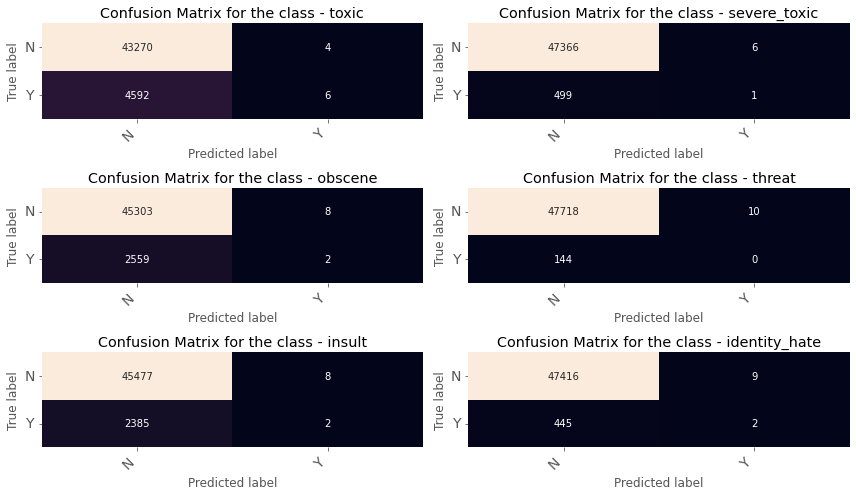

In [ ]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    
fig, ax = plt.subplots(3, 2, figsize=(12, 7))

cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']    

for axes, cfs_matrix, label in zip(ax.flatten(), cfs, cols_target):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])


fig.tight_layout()

plt.show()

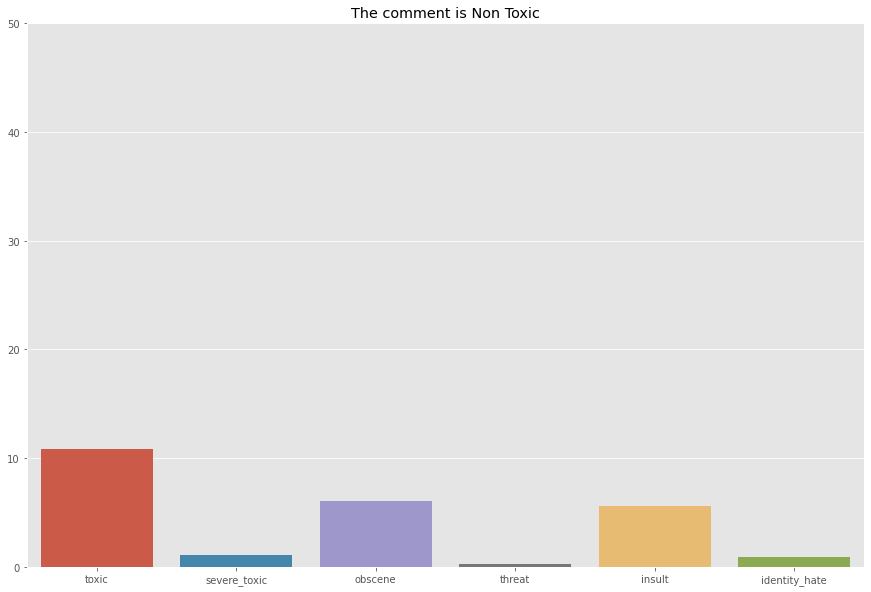

In [ ]:
def make_test_predictions(df,classifier):


    X_test = df.comment_text

    X_test_transformed = vect.transform(X_test)

    y_test_pred = classifier.predict_proba(X_test_transformed)

    a = np.array(y_test_pred[0])
    sns.barplot(x = cols_target,y =a*100) 
    plt.ylim((0,50))  
    result =  sum(y_test_pred[0])

    if result >= 1:

       plt.title('The comment is Toxic')
    else :
       plt.title('The comment is Non Toxic')
#Enter the comment
comment_text = "how can you say that stupid"

comment ={'id':[1],'comment_text':[comment_text]}

comment = pd.DataFrame(comment)

make_test_predictions(comment,model)


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Step 1: Data Preprocessing

train_df.drop(['id'], axis=1, inplace=True)

# Text cleaning
corpus = []
ps = PorterStemmer()
for i in range(len(train_df)):
    comment = re.sub('[^a-zA-Z]', ' ', train_df['comment_text'][i])
    comment = comment.lower()
    comment = comment.split()
    comment = [ps.stem(word) for word in comment if not word in set(stopwords.words('english'))]
    comment = ' '.join(comment)
    corpus.append(comment)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus, train_df.iloc[:,1:].values, test_size=0.2, random_state=42)

# Step 2: Feature Extraction
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

# Step 3: Model Training
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

# Step 5: Model Tuning
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(lr, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Step 6: Model Deployment
# Once the model is fine-tuned, it can be deployed on a web application or API for real-time classification of toxic comments.


NameError: name 'train_df' is not defined

In [ ]:
submission = pd.concat([test_df['id'], y_test], axis=1)

# write the submission DataFrame to a CSV file
submission.to_csv('submission1.csv', index=False)

In [ ]:
test_data= pd.read_csv('test.csv')
test_data.head(5)

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,dfasdf234,0,0,0,0,0,0
1,asdfgw43r52,0,0,1,1,0,1
2,asdgtawe4,0,0,1,0,1,1
3,wqtr215432,0,0,0,1,0,0


In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>